# Final Project Submission

Please fill out:
* Student name: Hiten Patel 
* Student pace: Full Time Online 
* Scheduled project review date/time: 10/17: 10AM
* Instructor name: James Irving 
* Blog post URL: https://hpatel530.github.io/blog_number_4_by_hiten_patel


# Chicago Car Crash: Predicting the Cause of Traffic Accidents 

## Introduction 

# Obtain 

## Import Packages 

In [149]:
#!pip install scikit-learn==0.23.2

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn import metrics  
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler



from sklearn.compose import ColumnTransformer
# from sklearn import set_config
# set_config(display='diagram')

#!pip install shap
import shap 
shap.initjs()

import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import warnings
warnings.filterwarnings('ignore')

## Functions 

In [227]:
def evaluate_classification(model, X_train_tf, X_test_tf, y_train, y_test, classes = None, 
                            normalize = 'true', cmap='ocean', label = ''):
    
    """Input a model, training data and test data to return sklearn metrics
        - Classification Report for training and test 
        - Confusion Matrix 
        - ROC Curve 
    """
    # retrieve predictions for train and test data 
    y_pred_train = model.predict(X_train_tf)
    y_pred_test = model.predict(X_test_tf)
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names = classes))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(10,4), ncols=2)
    
    # confusion matrix 
    plot_confusion_matrix(model, X_train_tf, y_train, labels=classes, normalize = normalize,
                         cmap = cmap, ax=axes[0])
    
    axes[0].set(title = 'Confusion Matrix Training')
    
    # plot ROC curve 
    plot_roc_curve(model, X_train_tf, y_train, ax=axes[1])
    roc = axes[1]
    roc.legend()
    roc.plot([0,1], [0,1], ls=':')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Training')
    plt.show()
    
    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names = classes))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(10,4), ncols=2)
    
    # confusion matrix 
    plot_confusion_matrix(model, X_test_tf, y_test,  labels=classes, normalize = normalize, 
                          cmap = cmap, ax=axes[0])
  
    
    axes[0].set(title = 'Confusion Matrix Testing')
    
    # plot ROC curve 
    plot_roc_curve(model, X_test_tf, y_test, ax=axes[1])
    roc = axes[1]
    roc.legend()
    roc.plot([0,1], [0,1], ls=':')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Test')
    plt.show()

## Import Data

### Data Source 1: crash 

In [151]:
# importing database one and observe 
pd.set_option('display.max_columns', None)
crash = pd.read_csv('https://data.cityofchicago.org/resource/85ca-t3if.csv')
print(crash.shape)
display(crash.head())
crash.info()

(1000, 49)


,crash_record_id,rd_no,crash_date_est_i,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,private_property_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location
0,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,NaN,NaN,2020-10-14T00:33:00.000,30,STOP SIGN/FLASHER,OTHER,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",2020-10-14T00:33:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,3758,W,OHIO ST,1122,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,4,10,41.891850,-87.721016,POINT (-87.721015866164 41.8918497779)
1,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,NaN,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,Y,"OVER $1,500",2020-10-14T00:15:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,2530,W,PRATT BLVD,2411,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,4,10,42.005082,-87.693661,POINT (-87.693660959344 42.005081868713)
2,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,NaN,NaN,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,Y,NaN,Y,"OVER $1,500",2020-10-13T23:42:00.000,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,12159,S,PRINCETON AVE,523,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,2.0,0.0,0.0,2.0,0.0,1.0,0.0,23,3,10,41.672575,-87.629564,POINT (-87.629564171395 41.672575037057)
3,b5187c75caa5e2fa899c2f95d60a77bf713532c806cae4...,NaN,NaN,2020-10-13T22:41:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,CENTER TURN LANE,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2020-10-13T23:01:00.000,IMPROPER LANE USAGE,UNABLE TO DETERMINE,6400,N,SHERIDAN RD,2432,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,22,3,10,41.998218,-87.660695,POINT (-87.660695255572 41.998217920532)
4,42a59bf2b5eb302ab2ebfff40341c7113b7bd70a2acf2d...,NaN,NaN,2020-10-13T22:00:00.000,30,UNKNOWN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,Y,"$501 - $1,500",2020-10-13T22:00:00.000,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1138,N,HAMLIN AVE,1112,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,3,10,41.902053,-87.721557,POINT (-87.721557289254 41.902052838561)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_record_id                1000 non-null   object 
 1   rd_no                          0 non-null      float64
 2   crash_date_est_i               74 non-null     object 
 3   crash_date                     1000 non-null   object 
 4   posted_speed_limit             1000 non-null   int64  
 5   traffic_control_device         1000 non-null   object 
 6   device_condition               1000 non-null   object 
 7   weather_condition              1000 non-null   object 
 8   lighting_condition             1000 non-null   object 
 9   first_crash_type               1000 non-null   object 
 10  trafficway_type                1000 non-null   object 
 11  lane_cnt                       0 non-null      float64
 12  alignment                      1000 non-null   ob

### Data Source 2: vehicle 


In [152]:
# importing database two and observe 
vehicle = pd.read_csv('https://data.cityofchicago.org/resource/68nd-jvt3.csv')
print(vehicle.shape)
display(vehicle.head())
vehicle.info()

(1000, 72)


,crash_unit_id,crash_record_id,rd_no,crash_date,unit_no,unit_type,num_passengers,vehicle_id,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class
0,976342,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,NaN,2020-10-14T00:33:00.000,1,DRIVER,NaN,925246.0,NaN,BMW,5 SERIES,IL,2008.0,UNKNOWN,PASSENGER,PERSONAL,S,UNKNOWN/NA,Y,NaN,1.0,NaN,city of chicago,6,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,976351,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,2020-10-14T00:13:00.000,1,DRIVER,1.0,925254.0,NaN,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,2.0,NaN,CITY OF CHICAGO,POUND 6,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,976352,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,2020-10-14T00:13:00.000,2,PARKED,NaN,925257.0,NaN,TOYOTA,RAV4,IL,2011.0,UNKNOWN,SPORT UTILITY VEHICLE (SUV),NOT IN USE,W,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,976346,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,NaN,2020-10-13T23:42:00.000,1,DRIVER,NaN,925249.0,NaN,FORD,EDGE,IL,NaN,UNKNOWN,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,976347,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,NaN,2020-10-13T23:42:00.000,2,DRIVER,1.0,925253.0,NaN,HONDA,FIT,IL,2013.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,2.0,NaN,PERSONAL TOW,NaN,NaN,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIDE-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   crash_unit_id             1000 non-null   int64  
 1   crash_record_id           1000 non-null   object 
 2   rd_no                     0 non-null      float64
 3   crash_date                1000 non-null   object 
 4   unit_no                   1000 non-null   int64  
 5   unit_type                 999 non-null    object 
 6   num_passengers            160 non-null    float64
 7   vehicle_id                977 non-null    float64
 8   cmrc_veh_i                20 non-null     object 
 9   make                      977 non-null    object 
 10  model                     977 non-null    object 
 11  lic_plate_state           890 non-null    object 
 12  vehicle_year              820 non-null    float64
 13  vehicle_defect            977 non-null    object 
 14  vehicle_t

### Data Source 3: person 

In [153]:
# importing database three and observe 
person = pd.read_csv('https://data.cityofchicago.org/resource/u6pd-qa9d.csv')
print(person.shape)
display(person.head())
person.info()

(1000, 30)


,person_id,person_type,crash_record_id,rd_no,vehicle_id,crash_date,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result_value,cell_phone_use
0,O976342,DRIVER,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,NaN,925246.0,2020-10-14T00:33:00.000,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O976351,DRIVER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,925254.0,2020-10-14T00:13:00.000,NaN,CHICAGO,IL,60645.0,M,18.0,IL,NaN,USAGE UNKNOWN,"DEPLOYED, FRONT",NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,OTHER,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,P222123,PASSENGER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,925254.0,2020-10-14T00:13:00.000,3.0,NaN,IL,NaN,M,NaN,NaN,NaN,USAGE UNKNOWN,"DEPLOYED, FRONT",NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O976346,DRIVER,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,NaN,925249.0,2020-10-13T23:42:00.000,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,USAGE UNKNOWN,"DEPLOYED, COMBINATION",NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,FAILED TO YIELD,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O976347,DRIVER,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,NaN,925253.0,2020-10-13T23:42:00.000,NaN,CHICAGO,IL,60628.0,F,26.0,IL,D,SAFETY BELT USED,"DEPLOYED, COMBINATION",NONE,NONINCAPACITATING INJURY,ROSELAND,#5,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_id              1000 non-null   object 
 1   person_type            1000 non-null   object 
 2   crash_record_id        1000 non-null   object 
 3   rd_no                  0 non-null      float64
 4   vehicle_id             981 non-null    float64
 5   crash_date             1000 non-null   object 
 6   seat_no                216 non-null    float64
 7   city                   725 non-null    object 
 8   state                  737 non-null    object 
 9   zipcode                662 non-null    float64
 10  sex                    982 non-null    object 
 11  age                    727 non-null    float64
 12  drivers_license_state  577 non-null    object 
 13  drivers_license_class  470 non-null    object 
 14  safety_equipment       997 non-null    object 
 15  airba

# Scrub 

## Data Source 1: Remove Irrelevant Columns 

In [154]:
# dropping following columns due to irrelevance in predicting the cause of car accidents 
# irrelevent columns were dropped due to column description
drop = ['rd_no', 'crash_date_est_i', 'report_type', 'crash_type', 'damage', 'date_police_notified', 
        'photos_taken_i', 'statements_taken_i', 'injuries_fatal', 'injuries_incapacitating', 'most_severe_injury',
        'injuries_non_incapacitating','injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown']
crash = crash.drop(columns = drop)
print(crash.shape)
crash.head()

(1000, 34)


,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,intersection_related_i,private_property_i,hit_and_run_i,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location
0,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,2020-10-14T00:33:00.000,30,STOP SIGN/FLASHER,OTHER,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,3758,W,OHIO ST,1122,NaN,NaN,NaN,NaN,1,0.0,0,4,10,41.891850,-87.721016,POINT (-87.721015866164 41.8918497779)
1,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2530,W,PRATT BLVD,2411,NaN,NaN,NaN,NaN,2,0.0,0,4,10,42.005082,-87.693661,POINT (-87.693660959344 42.005081868713)
2,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,NaN,Y,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,12159,S,PRINCETON AVE,523,NaN,NaN,NaN,NaN,2,2.0,23,3,10,41.672575,-87.629564,POINT (-87.629564171395 41.672575037057)
3,b5187c75caa5e2fa899c2f95d60a77bf713532c806cae4...,2020-10-13T22:41:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,CENTER TURN LANE,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,NaN,NaN,IMPROPER LANE USAGE,UNABLE TO DETERMINE,6400,N,SHERIDAN RD,2432,NaN,NaN,NaN,NaN,2,0.0,22,3,10,41.998218,-87.660695,POINT (-87.660695255572 41.998217920532)
4,42a59bf2b5eb302ab2ebfff40341c7113b7bd70a2acf2d...,2020-10-13T22:00:00.000,30,UNKNOWN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,Y,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1138,N,HAMLIN AVE,1112,NaN,NaN,NaN,NaN,2,0.0,22,3,10,41.902053,-87.721557,POINT (-87.721557289254 41.902052838561)


## Data Source 2: Remove Irrelevant Columns 

In [155]:
#dropped duplicate columns found in the first data source and irrevelant columns
#irrelevent columns were dropped due to column description
drop = ['rd_no', 'crash_date', 'towed_i', 'fire_i', 'towed_by', 'towed_to', 'area_00_i', 
      'area_01_i', 'area_02_i', 'area_03_i', 'area_04_i', 'area_05_i', 'area_06_i', 'area_07_i',
      'area_08_i', 'area_09_i', 'area_10_i', 'area_11_i', 'area_12_i', 'area_99_i']
vehicle = vehicle.drop(columns=drop)
print(vehicle.shape)
vehicle.head()

(1000, 52)


,crash_unit_id,crash_record_id,unit_no,unit_type,num_passengers,vehicle_id,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,exceed_speed_limit_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class
0,976342,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,1,DRIVER,NaN,925246.0,NaN,BMW,5 SERIES,IL,2008.0,UNKNOWN,PASSENGER,PERSONAL,S,UNKNOWN/NA,1.0,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,976351,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,1,DRIVER,1.0,925254.0,NaN,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,976352,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,2,PARKED,NaN,925257.0,NaN,TOYOTA,RAV4,IL,2011.0,UNKNOWN,SPORT UTILITY VEHICLE (SUV),NOT IN USE,W,PARKED,0.0,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,976346,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,1,DRIVER,NaN,925249.0,NaN,FORD,EDGE,IL,NaN,UNKNOWN,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,1.0,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,976347,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,2,DRIVER,1.0,925253.0,NaN,HONDA,FIT,IL,2013.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,NaN,SIDE-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Source 3: Remove Irrelevant Columns

In [156]:
print(person.shape)
drop = ['rd_no', 'crash_date', 'seat_no', 'safety_equipment', 'airbag_deployed', 'ejection',
       'injury_classification', 'hospital', 'ems_agency', 'ems_run_no']
person = person.drop(columns=drop)
print(person.shape)
person.head()

(1000, 30)
(1000, 20)


,person_id,person_type,crash_record_id,vehicle_id,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result_value,cell_phone_use
0,O976342,DRIVER,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,925246.0,NaN,NaN,NaN,X,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O976351,DRIVER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,925254.0,CHICAGO,IL,60645.0,M,18.0,IL,NaN,OTHER,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,P222123,PASSENGER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,925254.0,NaN,IL,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O976346,DRIVER,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,925249.0,NaN,NaN,NaN,M,NaN,NaN,NaN,FAILED TO YIELD,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O976347,DRIVER,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,925253.0,CHICAGO,IL,60628.0,F,26.0,IL,D,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


## Merging Data = df 

In [157]:
# merging all three data sources into 1, observing shape and previewing data 
merged = pd.merge(left=crash, right = vehicle, left_on='crash_record_id', right_on="crash_record_id")
df = pd.merge(left=merged, right=person, left_on = 'vehicle_id', right_on='vehicle_id')
print(df.shape)
df.head()

(1418, 104)


,crash_record_id_x,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,intersection_related_i,private_property_i,hit_and_run_i,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,unit_no,unit_type,num_passengers,vehicle_id,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,exceed_speed_limit_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,crash_record_id_y,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result_value,cell_phone_use
0,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,2020-10-14T00:33:00.000,30,STOP SIGN/FLASHER,OTHER,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,3758,W,OHIO ST,1122,NaN,NaN,NaN,NaN,1,0.0,0,4,10,41.891850,-87.721016,POINT (-87.721015866164 41.8918497779),976342,1,DRIVER,NaN,925246.0,NaN,BMW,5 SERIES,IL,2008.0,UNKNOWN,PASSENGER,PERSONAL,S,UNKNOWN/NA,1.0,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O976342,DRIVER,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,NaN,NaN,NaN,X,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2530,W,PRATT BLVD,2411,NaN,NaN,NaN,NaN,2,0.0,0,4,10,42.005082,-87.693661,POINT (-87.693660959344 42.005081868713),976351,1,DRIVER,1.0,925254.0,NaN,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O976351,DRIVER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,CHICAGO,IL,60645.0,M,18.0,IL,NaN,OTHER,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2530,W,PRATT BLVD,2411,NaN,NaN,NaN,NaN,2,0.0,0,4,10,42.005082,-87.693661,POINT (-87.693660959344 42.005081868713),976351,1,DRIVER,1.0,925254.0,NaN,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P222123,PASSENGER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,IL,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,NaN,Y,FAILING TO YIELD RIGHT-OF-WA

## Calculating Nulls/Column 

In [158]:
# calculating nulls
nulls = df.isna().sum()
null_percent = nulls[nulls>0] / len(df)
null_percent.to_frame('% Null').style.background_gradient(cmap='Reds')

,% Null
lane_cnt,1.000000
intersection_related_i,0.627645
private_property_i,0.954866
hit_and_run_i,0.648801
dooring_i,1.000000
work_zone_i,1.000000
work_zone_type,1.000000
workers_present_i,1.000000
latitude,0.002821
longitude,0.002821


In [159]:
# extracting columns with excesssive nulls which is set at 95%
Index_label = null_percent[null_percent>.95].index.tolist()
Index_label

['lane_cnt',
 'private_property_i',
 'dooring_i',
 'work_zone_i',
 'work_zone_type',
 'workers_present_i',
 'cmrc_veh_i',
 'exceed_speed_limit_i',
 'cmv_id',
 'usdot_no',
 'ccmc_no',
 'ilcc_no',
 'commercial_src',
 'gvwr',
 'carrier_name',
 'carrier_state',
 'carrier_city',
 'hazmat_placards_i',
 'hazmat_name',
 'un_no',
 'hazmat_present_i',
 'hazmat_report_i',
 'hazmat_report_no',
 'mcs_report_i',
 'mcs_report_no',
 'hazmat_vio_cause_crash_i',
 'mcs_vio_cause_crash_i',
 'idot_permit_no',
 'wide_load_i',
 'trailer1_width',
 'trailer2_width',
 'trailer1_length',
 'trailer2_length',
 'total_vehicle_length',
 'axle_cnt',
 'vehicle_config',
 'cargo_body_type',
 'load_type',
 'hazmat_out_of_service_i',
 'mcs_out_of_service_i',
 'hazmat_class',
 'bac_result_value',
 'cell_phone_use']

## Dropping Columns w/ Excessive Nulls

In [160]:
# previewing shape, data and info 
df = df.drop(columns = Index_label)
print(df.shape)
display(df.head())
df.info()

(1418, 61)


,crash_record_id_x,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,intersection_related_i,hit_and_run_i,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,unit_no,unit_type,num_passengers,vehicle_id,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,first_contact_point,person_id,person_type,crash_record_id_y,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result
0,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,2020-10-14T00:33:00.000,30,STOP SIGN/FLASHER,OTHER,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,3758,W,OHIO ST,1122,1,0.0,0,4,10,41.891850,-87.721016,POINT (-87.721015866164 41.8918497779),976342,1,DRIVER,NaN,925246.0,BMW,5 SERIES,IL,2008.0,UNKNOWN,PASSENGER,PERSONAL,S,UNKNOWN/NA,1.0,OTHER,O976342,DRIVER,af1c6f0ae0dfa8824e8f84f516136209989fb974edfbdc...,NaN,NaN,NaN,X,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
1,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2530,W,PRATT BLVD,2411,2,0.0,0,4,10,42.005082,-87.693661,POINT (-87.693660959344 42.005081868713),976351,1,DRIVER,1.0,925254.0,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,OTHER,O976351,DRIVER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,CHICAGO,IL,60645.0,M,18.0,IL,NaN,OTHER,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
2,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2530,W,PRATT BLVD,2411,2,0.0,0,4,10,42.005082,-87.693661,POINT (-87.693660959344 42.005081868713),976351,1,DRIVER,1.0,925254.0,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,OTHER,P222123,PASSENGER,595d965d96ec041ec8736e519f69e0499ca5aa79332de3...,NaN,IL,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,Y,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,12159,S,PRINCETON AVE,523,2,2.0,23,3,10,41.672575,-87.629564,POINT (-87.629564171395 41.672575037057),976346,1,DRIVER,NaN,925249.0,FORD,EDGE,IL,NaN,UNKNOWN,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,1.0,OTHER,O976346,DRIVER,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,NaN,NaN,NaN,M,NaN,NaN,NaN,FAILED TO YIELD,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
4,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,Y,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,12159,S,PRINCETON AVE,523,2,2.0,23,3,10,41.672575,-87.629564,POINT (-87.629564171395 41.672575037057),976347,2,DRIVER,1.0,925253.0,HONDA,FIT,IL,2013.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,SIDE-RIGHT,O976347,DRIVER,1e71e0b6362d503e05fafc0b73db3eeb202dbf93c9a3f0...,CHICAGO,IL,60628.0,F,26.0,IL,D,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418 entries, 0 to 1417
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crash_record_id_x        1418 non-null   object 
 1   crash_date               1418 non-null   object 
 2   posted_speed_limit       1418 non-null   int64  
 3   traffic_control_device   1418 non-null   object 
 4   device_condition         1418 non-null   object 
 5   weather_condition        1418 non-null   object 
 6   lighting_condition       1418 non-null   object 
 7   first_crash_type         1418 non-null   object 
 8   trafficway_type          1418 non-null   object 
 9   alignment                1418 non-null   object 
 10  roadway_surface_cond     1418 non-null   object 
 11  road_defect              1418 non-null   object 
 12  intersection_related_i   528 non-null    object 
 13  hit_and_run_i            498 non-null    object 
 14  prim_contributory_cause 

## Dropping Redundant Columns

In [161]:
# dropping redundant columns, previewing shape, data and info 
drop = ['crash_record_id_x','crash_unit_id', 'vehicle_id', 'person_id', "crash_record_id_y", 'street_no', 'street_direction',
       'street_name', 'location', 'zipcode']
df = df.drop(columns=drop)
print(df.shape)
display(df.head())
df.info()

(1418, 51)


,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,intersection_related_i,hit_and_run_i,prim_contributory_cause,sec_contributory_cause,beat_of_occurrence,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,latitude,longitude,unit_no,unit_type,num_passengers,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,first_contact_point,person_type,city,state,sex,age,drivers_license_state,drivers_license_class,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result
0,2020-10-14T00:33:00.000,30,STOP SIGN/FLASHER,OTHER,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,1122,1,0.0,0,4,10,41.891850,-87.721016,1,DRIVER,NaN,BMW,5 SERIES,IL,2008.0,UNKNOWN,PASSENGER,PERSONAL,S,UNKNOWN/NA,1.0,OTHER,DRIVER,NaN,NaN,X,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
1,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2411,2,0.0,0,4,10,42.005082,-87.693661,1,DRIVER,1.0,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,OTHER,DRIVER,CHICAGO,IL,M,18.0,IL,NaN,OTHER,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
2,2020-10-14T00:13:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,Y,UNABLE TO DETERMINE,NOT APPLICABLE,2411,2,0.0,0,4,10,42.005082,-87.693661,1,DRIVER,1.0,TOYOTA,COROLLA,IL,1999.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,OTHER,PASSENGER,NaN,IL,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,Y,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,523,2,2.0,23,3,10,41.672575,-87.629564,1,DRIVER,NaN,FORD,EDGE,IL,NaN,UNKNOWN,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,1.0,OTHER,DRIVER,NaN,NaN,M,NaN,NaN,NaN,FAILED TO YIELD,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
4,2020-10-13T23:42:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,Y,Y,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,523,2,2.0,23,3,10,41.672575,-87.629564,2,DRIVER,1.0,HONDA,FIT,IL,2013.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,2.0,SIDE-RIGHT,DRIVER,CHICAGO,IL,F,26.0,IL,D,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418 entries, 0 to 1417
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crash_date               1418 non-null   object 
 1   posted_speed_limit       1418 non-null   int64  
 2   traffic_control_device   1418 non-null   object 
 3   device_condition         1418 non-null   object 
 4   weather_condition        1418 non-null   object 
 5   lighting_condition       1418 non-null   object 
 6   first_crash_type         1418 non-null   object 
 7   trafficway_type          1418 non-null   object 
 8   alignment                1418 non-null   object 
 9   roadway_surface_cond     1418 non-null   object 
 10  road_defect              1418 non-null   object 
 11  intersection_related_i   528 non-null    object 
 12  hit_and_run_i            498 non-null    object 
 13  prim_contributory_cause  1418 non-null   object 
 14  sec_contributory_cause  

In [162]:
df.model.value_counts()

OTHER (EXPLAIN IN NARRATIVE)    172
CAMRY                            34
MALIBU                           24
COROLLA                          22
ALTIMA                           19
                               ... 
ESCORT                            1
ATLAS                             1
RX300                             1
TELLURIDE                         1
CL                                1
Name: model, Length: 217, dtype: int64

## Identifying/Cleaning Target

In [163]:
# creating classes: 0 = not injured, 1 = injured
df['injuries_total'] = df['injuries_total'].map(lambda x: 1 if x > 0 else 0)

In [164]:
# renaming column 
df.rename(columns = {'injuries_total':'Injured'}, inplace = True) 

In [165]:
# reviewing classification 
df.Injured.value_counts()

0    893
1    525
Name: Injured, dtype: int64

## Final Scrub: Converting Datatypes

In [166]:
# retreiving year from date 
crash_year = []
for year in df.crash_date:
    crash_year.append(year[0:4])
    
print (crash_year)

['2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020',

In [167]:
# adding new column crash_year 
df['crash_year'] = crash_year

In [168]:
# dropping redundant column 
df = df.drop(columns='crash_date')

In [169]:
# converting columns to appropriate data types 

df['posted_speed_limit'] = df['posted_speed_limit'].astype('str')
df['beat_of_occurrence'] = df['beat_of_occurrence'].astype('str')
df['crash_hour'] = df['crash_hour'].astype('str')
df['crash_day_of_week'] = df['crash_day_of_week'].astype('str')
df['crash_month'] = df['crash_month'].astype('str')
df['vehicle_year'] = df['vehicle_year'].astype('str')
df['Injured'] = df['Injured'].astype('str')


In [170]:
# reviewing dataframe info 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418 entries, 0 to 1417
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   posted_speed_limit       1418 non-null   object 
 1   traffic_control_device   1418 non-null   object 
 2   device_condition         1418 non-null   object 
 3   weather_condition        1418 non-null   object 
 4   lighting_condition       1418 non-null   object 
 5   first_crash_type         1418 non-null   object 
 6   trafficway_type          1418 non-null   object 
 7   alignment                1418 non-null   object 
 8   roadway_surface_cond     1418 non-null   object 
 9   road_defect              1418 non-null   object 
 10  intersection_related_i   528 non-null    object 
 11  hit_and_run_i            498 non-null    object 
 12  prim_contributory_cause  1418 non-null   object 
 13  sec_contributory_cause   1418 non-null   object 
 14  beat_of_occurrence      

# Explore

In [171]:
# reviewing numerical data 
df.describe()

,num_units,latitude,longitude,unit_no,num_passengers,occupant_cnt,age
count,1418.000000,1414.000000,1414.000000,1418.000000,353.000000,981.000000,1123.000000
mean,2.177010,41.866806,-87.684107,1.638928,1.798867,1.636086,37.640249
std,0.714094,0.081455,0.055188,0.623652,1.088054,1.078114,18.337854
min,1.000000,41.654739,-87.898242,1.000000,1.000000,1.000000,0.000000
25%,2.000000,41.795552,-87.724689,1.000000,1.000000,1.000000,23.000000
50%,2.000000,41.880525,-87.685355,2.000000,1.000000,1.000000,34.000000
75%,2.000000,41.921366,-87.640617,2.000000,2.000000,2.000000,51.000000
max,7.000000,42.017830,-87.532926,5.000000,5.000000,6.000000,82.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e2b874cc0>,
      dtype=object)

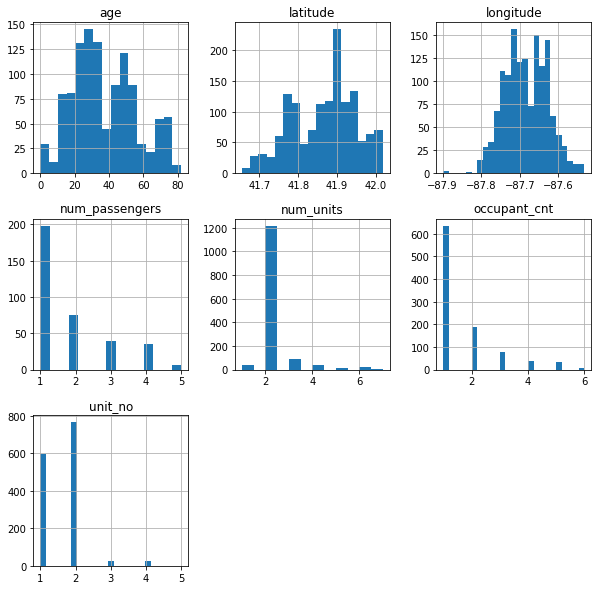

In [172]:
# observing histograms for data 
df.hist(bins='auto', figsize=(10,10))

# Train-Test-Split


In [173]:
# setting X, y for train-test-split
target = 'Injured'
X = df.drop(columns= target)
y = df[target]

# train-test-split, test_size = 25%, random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

## Preprocessing Numerical 

In [262]:
# retrieving list of numeric columns 
num_cols = df.drop(columns=target).select_dtypes('number').columns.tolist()
num_cols

['num_units',
 'latitude',
 'longitude',
 'unit_no',
 'num_passengers',
 'occupant_cnt',
 'age']

In [175]:
# creating a pipeline 
# SimpleImputer will use the median to fill nulls  
# RobustScaler will use the median to scale 
num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scale', RobustScaler())])

## Preprocessing Categorical 

In [176]:
# retrieving list of categorical columns 
cat_cols = df.drop(columns=target).select_dtypes('object').columns.tolist()

In [177]:
# creating a pipeline
# SimpleImputer will use strategy 'constant' == 'missing value' input for objects
# OneHotEncoder will scale the categorical data to a binary column
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant')),
                         ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

## ColumnTransformer

In [178]:
# combine both pipelines into one using columntransformer 
preprocessing = ColumnTransformer([('num', num_transform, num_cols), 
                                  ('cat', cat_transform, cat_cols)])

#preprocessing  our X_train data and our X_test to use in models 

X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [179]:
# accessing categorical columns from pipeline then converting to dataframe
slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf

num_units  latitude  longitude  unit_no  num_passengers  occupant_cnt  \
0           0.0  0.232135   0.406956      0.0             0.0           0.0   
1           0.0  0.682109  -0.305937     -1.0             0.0           0.0   
2           0.0  0.223542   0.233164      0.0             0.0           0.0   
3           0.0 -0.811032   1.273612     -1.0             0.0           0.0   
4           0.0  0.115716  -0.688216     -1.0             0.0           0.0   
...         ...       ...        ...      ...             ...           ...   
1058        0.0  0.276717   0.000000     -1.0             0.0           0.0   
1059        0.0  0.966712  -0.254538     -1.0             0.0           0.0   
1060        0.0  0.000000   0.000000     -1.0             0.0           0.0   
1061        0.0 -0.904805   0.335775     -1.0             0.0           0.0   
1062        0.0 -1.543178   0.536336     -1.0             0.0           0.0   

           age  posted_speed_limit_10  posted_speed_limit_15  \
0     0.772727                    0.0                    0.0   
1     0.863636                    0.0                    0.0   
2     1.772727                    0.0                    0.0   
3     0.000000                    0.0                    0.0   
4     0.000000                    0.0                    0.0   
...        ...                    ...                    ...   
1058  0.000000                    0.0                    0.0   
1059  0.000000                    1.0                    0.0   
1060  0.000000                    0.0                    0.0   
1061 -0.590909                    0.0                    0.0   
1062  0.000000                    0.0                    0.0   

      posted_speed_limit_20  posted_speed_limit_24  posted_speed_limit_25  \
0                       0.0                    0.0                    0.0   
1                       0.0                    0.0                    0.0   
2                       0.0                    0.0                    0.0   
3                       0.0                    0.0                    0.0   
4                       0.0                    0.0                    0.0   
...                     ...                    ...                    ...   
1058                    0.0                    0.0                    0.0   
1059                    0.0                    0.0                    0.0   
1060                    0.0                    0.0                    0.0   
1061                    0.0                    0.0                    0.0   
1062                    0.0                    0.0                    0.0   

      posted_speed_limit_30  posted_speed_limit_35  posted_speed_limit_40  \
0                       1.0                    0.0                    0.0   
1                       1.0                    0.0                    0.0   
2                       1.0                    0.0                    0.0   
3                       1.0                    0.0                    0.0   
4                       1.0                    0.0                    0.0   
...                     ...                    ...                    ...   
1058                    1.0                    0.0                    0.0   
1059                    0.0                    0.0                    0.0   
1060                    0.0                    1.0                    0.0   
1061                    1.0                    0.0                    0.0   
1062                    1.0                    0.0                    0.0   

      posted_speed_limit_45  posted_speed_limit_5  posted_speed_limit_65  \
0                       0.0                   0.0                    0.0   
1                       0.0                   0.0                    0.0   
2                       0.0                   0.0                    0.0   
3                       0.0                   0.0                    0.0   
4                       0.0                   0.0         

## Class Imbalance (SMOTE)

In [180]:
# observing y_train(classes) count 
y_train.value_counts()

0    671
1    392
Name: Injured, dtype: int64

In [181]:
# Using the SMOTE procedure to solve class imbalance problems 
X_train_tf, y_train = SMOTE().fit_resample(X_train_tf, y_train)

In [182]:
# reviewing SMOTE has been implemented 
pd.Series(y_train).value_counts()

1    671
0    671
dtype: int64

# Model 

## Logistic Regression 

In [183]:
# instantiate LogisticRegression 
log_reg = LogisticRegression()

### log_reg Vanilla Model 

In [184]:
# fit the model 
log_reg.fit(X_train_tf, y_train)

# predict
y_pred = log_reg.predict(X_test_tf)

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       671
           1       1.00      0.99      0.99       671

    accuracy                           0.99      1342
   macro avg       0.99      0.99      0.99      1342
weighted avg       0.99      0.99      0.99      1342



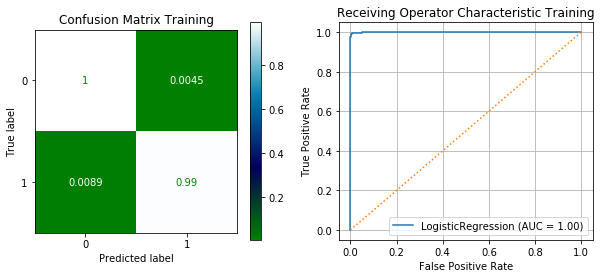

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       222
           1       0.93      0.86      0.89       133

    accuracy                           0.92       355
   macro avg       0.92      0.91      0.91       355
weighted avg       0.92      0.92      0.92       355



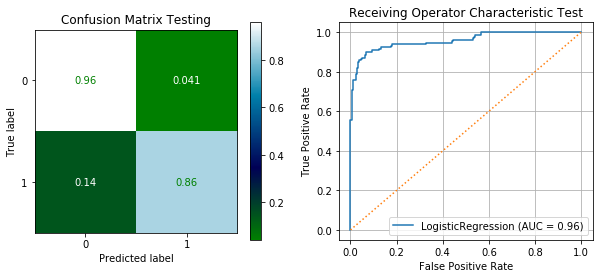

In [228]:
# classification report using function 
evaluate_classification(log_reg,X_train_tf, X_test_tf, y_train, y_test, label = "Logistic Regression")

### log_reg GridsearchCV

In [229]:
# create params_grid for LogisticRegression 
params_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'penalty' : ['l1', 'l2', 'elasticnet', None]}


# create grid search 
grid = GridSearchCV(log_reg, params_grid, cv=3) 

# fit x_train and y_train to grid 
gridlock = grid.fit(X_train_tf, y_train)

# observe combination of best params 
gridlock.best_params_

{'penalty': 'l2', 'solver': 'liblinear'}

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       671
           1       1.00      0.99      0.99       671

    accuracy                           0.99      1342
   macro avg       0.99      0.99      0.99      1342
weighted avg       0.99      0.99      0.99      1342



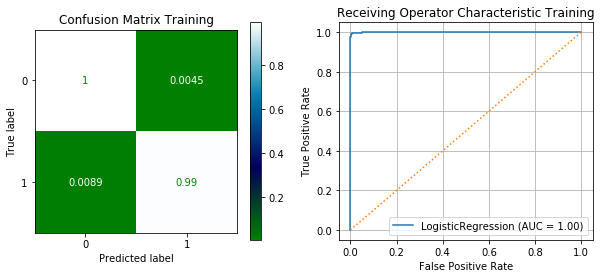

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       222
           1       0.93      0.86      0.89       133

    accuracy                           0.92       355
   macro avg       0.92      0.91      0.91       355
weighted avg       0.92      0.92      0.92       355



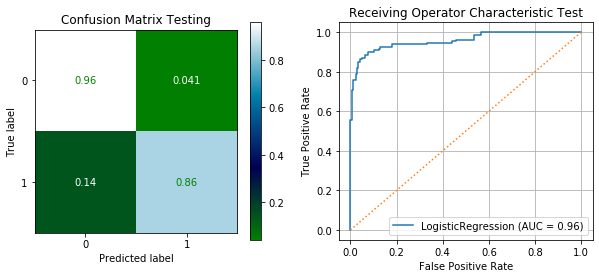

In [230]:
# evaluate model using functioan evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label ="Logistic Regression")

## KNN Model 

In [231]:
# instantiate KneighborsClassifier 
knn_clf = KNeighborsClassifier()

### knn_clf Vanilla Model 

In [232]:
# fit the model 
knn_clf.fit(X_train_tf, y_train)

# predict
y_pred = knn_clf.predict(X_test_tf)

------------------------------------------------------------
KNN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       671
           1       0.87      0.98      0.92       671

    accuracy                           0.92      1342
   macro avg       0.92      0.92      0.92      1342
weighted avg       0.92      0.92      0.92      1342



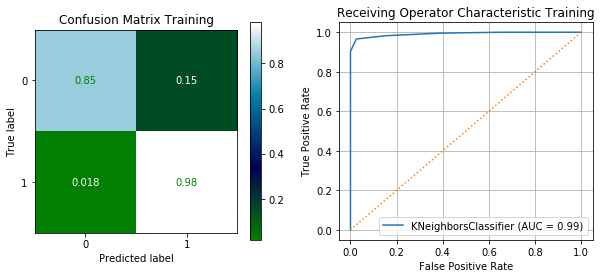

------------------------------------------------------------
KNN CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       222
           1       0.68      0.92      0.78       133

    accuracy                           0.81       355
   macro avg       0.81      0.83      0.81       355
weighted avg       0.84      0.81      0.81       355



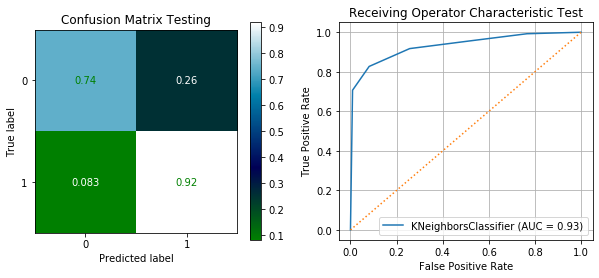

In [233]:
# classification report using function 
evaluate_classification(knn_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'KNN')

### knn_clf GridsearchCV

In [234]:
# create params_grid for KNeighborsClassifier  
params_grid = {'n_neighbors': [3, 5, 7, 9, 11, 21],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

# create grid search 
grid = GridSearchCV(knn_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

------------------------------------------------------------
KNN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       671

    accuracy                           1.00      1342
   macro avg       1.00      1.00      1.00      1342
weighted avg       1.00      1.00      1.00      1342



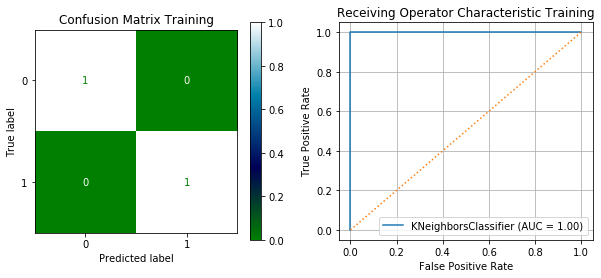

------------------------------------------------------------
KNN CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       222
           1       0.89      0.83      0.86       133

    accuracy                           0.90       355
   macro avg       0.90      0.88      0.89       355
weighted avg       0.90      0.90      0.90       355



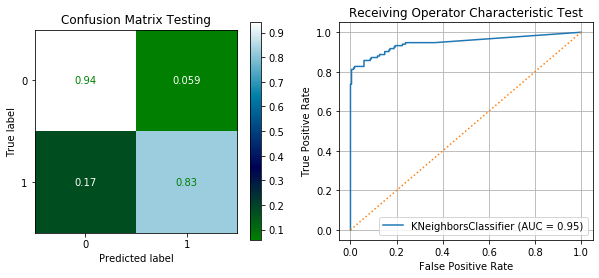

In [235]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, label='KNN')

## Decision Tree

In [236]:
# instantiate DecisionTreeClassifier 
tree_clf = DecisionTreeClassifier()

### tree_clf Vanilla Model 

In [237]:
# fit the model  
tree_clf.fit(X_train_tf, y_train)

# predict 
y_pred = tree_clf.predict(X_test_tf)

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       671

    accuracy                           1.00      1342
   macro avg       1.00      1.00      1.00      1342
weighted avg       1.00      1.00      1.00      1342



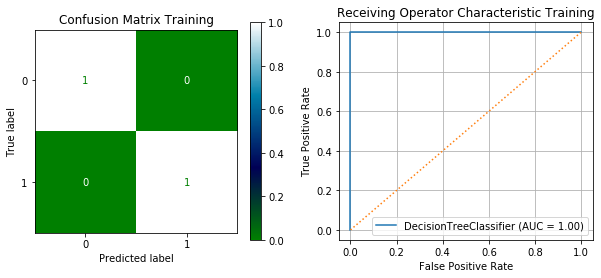

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       222
           1       0.94      0.89      0.92       133

    accuracy                           0.94       355
   macro avg       0.94      0.93      0.93       355
weighted avg       0.94      0.94      0.94       355



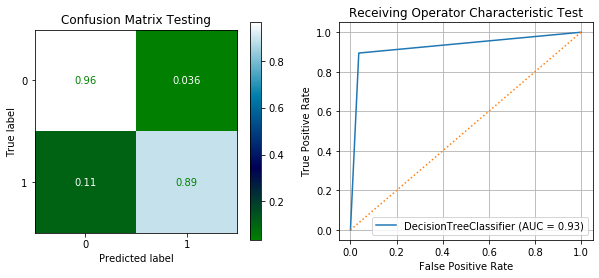

In [238]:
# classification report using function 
evaluate_classification(tree_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'Decision Tree')

### tree_clf GridsearchCV

In [241]:
# create params_grid for DecisionTreeClassifier  
params_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}

# create grid search 
grid = GridSearchCV(tree_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       671

    accuracy                           1.00      1342
   macro avg       1.00      1.00      1.00      1342
weighted avg       1.00      1.00      1.00      1342



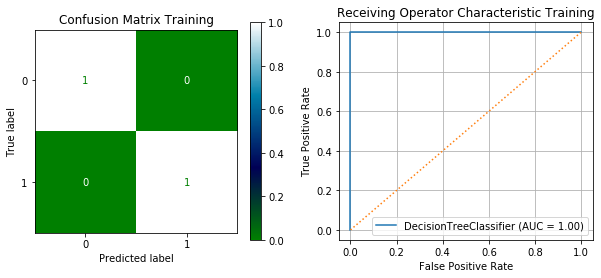

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       222
           1       0.93      0.89      0.91       133

    accuracy                           0.94       355
   macro avg       0.93      0.93      0.93       355
weighted avg       0.94      0.94      0.93       355



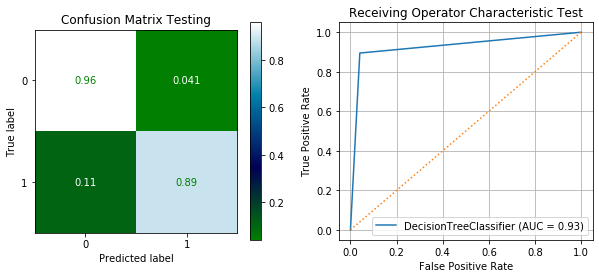

In [242]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Decision Tree')

## Bagged Trees 

In [251]:
# instantiate Bagging + DecisionTreeClassifier  
bag_clf = BaggingClassifier(base_estimator=RandomForestClassifier())

### bag_clf Vanilla Model 

In [252]:
# fit the model  
bag_clf.fit(X_train_tf, y_train)

# predict
y_pred = bag_clf.predict(X_test_tf)

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       671
           1       1.00      0.98      0.99       671

    accuracy                           0.99      1342
   macro avg       0.99      0.99      0.99      1342
weighted avg       0.99      0.99      0.99      1342



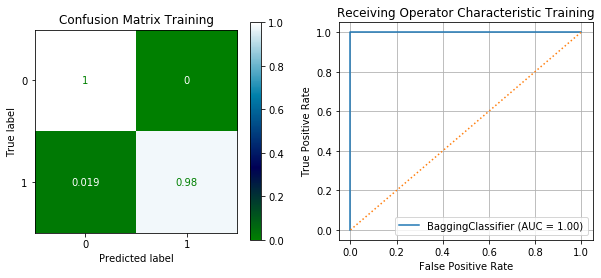

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       222
           1       1.00      0.74      0.85       133

    accuracy                           0.90       355
   macro avg       0.93      0.87      0.89       355
weighted avg       0.92      0.90      0.90       355



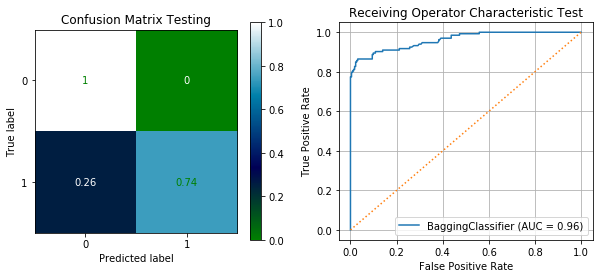

In [253]:
# classification report using function 
evaluate_classification(bag_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'Bagged Trees')

### bag_clf GridsearchCV

In [250]:
# create params_grid for BaggingClassifier
params_grid = {'bootstrap': [True, False],
               'bootstrap_features': [True, False],    
               'n_estimators': [5, 10, 15],
               'max_samples' : [0.6, 0.8, 1.0],
               'base_estimator__criterion': ['gini', 'entropy'],    
               'base_estimator__max_depth': [1, 5, 10, 15, None]}

# create grid search 
grid = GridSearchCV(bag_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'bootstrap': False,
 'bootstrap_features': True,
 'max_samples': 1.0,
 'n_estimators': 15}

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       671

    accuracy                           1.00      1342
   macro avg       1.00      1.00      1.00      1342
weighted avg       1.00      1.00      1.00      1342



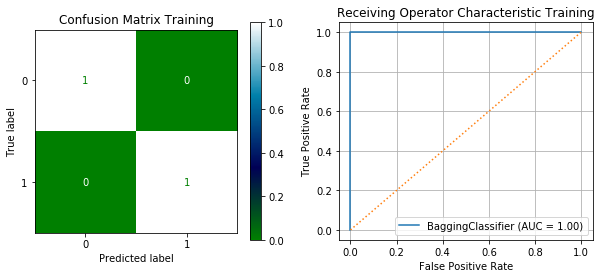

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       222
           1       0.97      0.87      0.92       133

    accuracy                           0.94       355
   macro avg       0.95      0.93      0.94       355
weighted avg       0.94      0.94      0.94       355



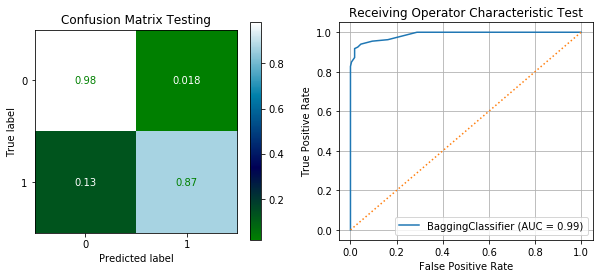

In [254]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Bagged Trees')

## Random Forest 

In [255]:
# instantiate RandomForestClassifier  
forest_clf = RandomForestClassifier()

### forest_clf Vanilla Model 

In [256]:
# fit the model 
forest_clf.fit(X_train_tf, y_train)

# get prediction 
y_pred = forest_clf.predict(X_test_tf)

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       671

    accuracy                           1.00      1342
   macro avg       1.00      1.00      1.00      1342
weighted avg       1.00      1.00      1.00      1342



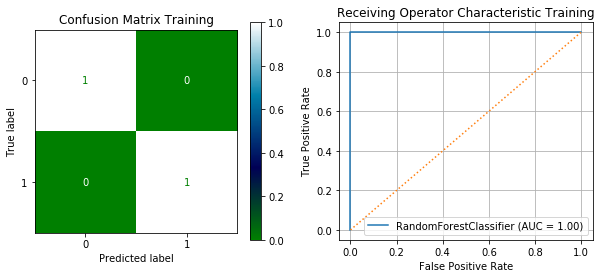

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       222
           1       1.00      0.75      0.86       133

    accuracy                           0.91       355
   macro avg       0.94      0.88      0.89       355
weighted avg       0.92      0.91      0.90       355



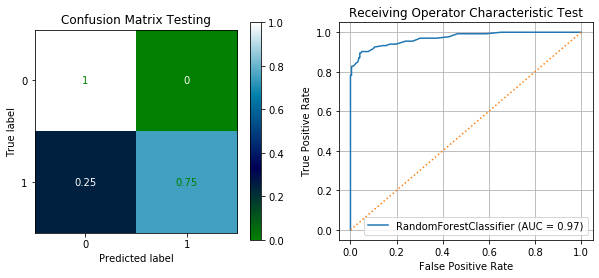

In [257]:
# classification report using function 
evaluate_classification(forest_clf,X_train_tf, X_test_tf, y_train, y_test, label = 'Random Forest')

### forest_clf GridsearchCV

In [208]:
# create params_grid for RandomForestClassifier 
params_grid = {'criterion': ['gini', 'entropy'],   
              'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [100, 200, 300, 400, 500]}

# create grid search 
grid = GridSearchCV(forest_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None}

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       671

    accuracy                           1.00      1342
   macro avg       1.00      1.00      1.00      1342
weighted avg       1.00      1.00      1.00      1342



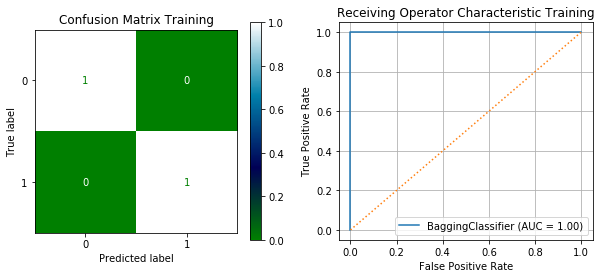

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       222
           1       0.97      0.87      0.92       133

    accuracy                           0.94       355
   macro avg       0.95      0.93      0.94       355
weighted avg       0.94      0.94      0.94       355



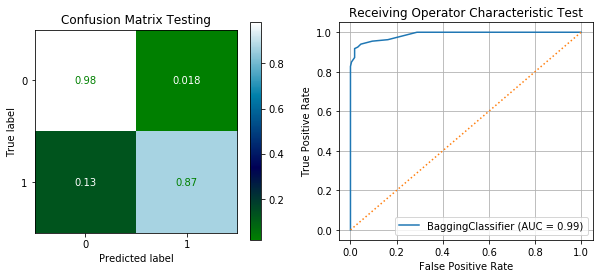

In [258]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Random Forest')

# iNtrepretation

In [259]:
# accessing categorical columns from pipeline then converting to dataframe
slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf

num_units  latitude  longitude  unit_no  num_passengers  occupant_cnt  \
0       0.00000  0.232135   0.406956  0.00000             0.0       0.00000   
1       0.00000  0.682109  -0.305937 -1.00000             0.0       0.00000   
2       0.00000  0.223542   0.233164  0.00000             0.0       0.00000   
3       0.00000 -0.811032   1.273612 -1.00000             0.0       0.00000   
4       0.00000  0.115716  -0.688216 -1.00000             0.0       0.00000   
...         ...       ...        ...      ...             ...           ...   
1337    0.31801  0.608353  -0.520348 -0.68199             0.0       0.31801   
1338    0.00000 -0.220906   0.462175  0.00000             0.0       0.00000   
1339    0.00000  0.074048   0.593998  0.00000             0.0       0.00000   
1340    2.00000 -0.641989  -0.654115 -0.81366             0.0       0.00000   
1341    0.00000  0.902449  -0.029012  0.00000             0.0       0.00000   

           age  posted_speed_limit_10  posted_speed_limit_15  \
0     0.772727                    0.0                    0.0   
1     0.863636                    0.0                    0.0   
2     1.772727                    0.0                    0.0   
3     0.000000                    0.0                    0.0   
4     0.000000                    0.0                    0.0   
...        ...                    ...                    ...   
1337 -0.208810                    0.0                    0.0   
1338  0.824283                    0.0                    0.0   
1339  1.851070                    0.0                    0.0   
1340 -0.084700                    0.0                    0.0   
1341 -0.425819                    0.0                    0.0   

      posted_speed_limit_20  posted_speed_limit_24  posted_speed_limit_25  \
0                       0.0                    0.0                    0.0   
1                       0.0                    0.0                    0.0   
2                       0.0                    0.0                    0.0   
3                       0.0                    0.0                    0.0   
4                       0.0                    0.0                    0.0   
...                     ...                    ...                    ...   
1337                    0.0                    0.0                    0.0   
1338                    0.0                    0.0                    0.0   
1339                    0.0                    0.0                    0.0   
1340                    0.0                    0.0                    0.0   
1341                    0.0                    0.0                    0.0   

      posted_speed_limit_30  posted_speed_limit_35  posted_speed_limit_40  \
0                       1.0                    0.0                    0.0   
1                       1.0                    0.0                    0.0   
2                       1.0                    0.0                    0.0   
3                       1.0                    0.0                    0.0   
4                       1.0                    0.0                    0.0   
...                     ...                    ...                    ...   
1337                    1.0                    0.0                    0.0   
1338                    1.0                    0.0                    0.0   
1339                    1.0                    0.0                    0.0   
1340                    1.0                    0.0                    0.0   
1341                    1.0                    0.0                    0.0   

      posted_speed_limit_45  posted_speed_limit_5  posted_speed_limit_65  \
0                       0.0                   0.0                    0.0   
1                       0.0                   0.0                    0.0   
2                       0.0                   0.0                    0.0   
3                       0.0                   0.0                    0.0   
4                       0.0                   0.0         

In [260]:
explainer = shap.TreeExplainer(forest_clf)
shap_values = explainer.shap_values(X_train_tf,y_train)
shap.summary_plot(shap_values,X_train_tf,plot_type='bar')

SystemError: <built-in function dense_tree_shap> returned a result with an error set

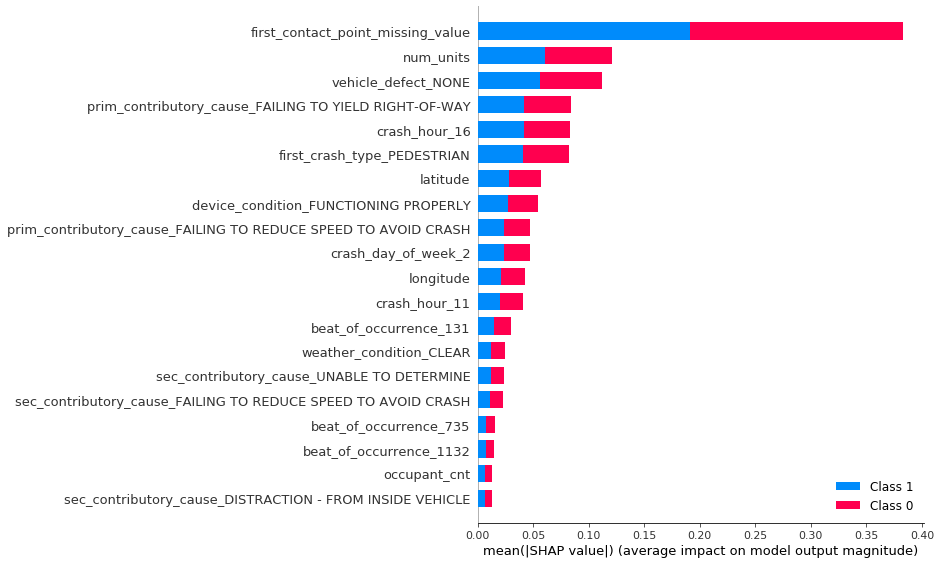

In [261]:
shap_values = shap.TreeExplainer(tree_clf).shap_values(X_train_tf)
shap.summary_plot(shap_values, X_train_tf)

In [ ]:
import sklearn
from sklearn import svm
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train_tf, y_train)
explainer = shap.KernelExplainer(svm.predict_proba, X_train_tf, link="logit")
shap_values = explainer.shap_values(X_test_tf, nsamples=10)
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_tf.iloc[0,:], link="logit")

Using 1342 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap.dependence_plot('crash_hour_2', shap_values, X_train_tf)

In [ ]:
shap.TreeExplainer(tree_clf).shap_interaction_values(X_train_tf)

# Conclusion 

# Future Work 